Forecast-then-Detect(robust)

Variable: PH_decPressureRinse5
Calibration size: 12476 / 17824 valid points
Median=7.950, MAD=0.070, sigma_MAD=0.104
Robust band: [7.639, 8.261] (K=3.0)
Predicted anomalies: 2385


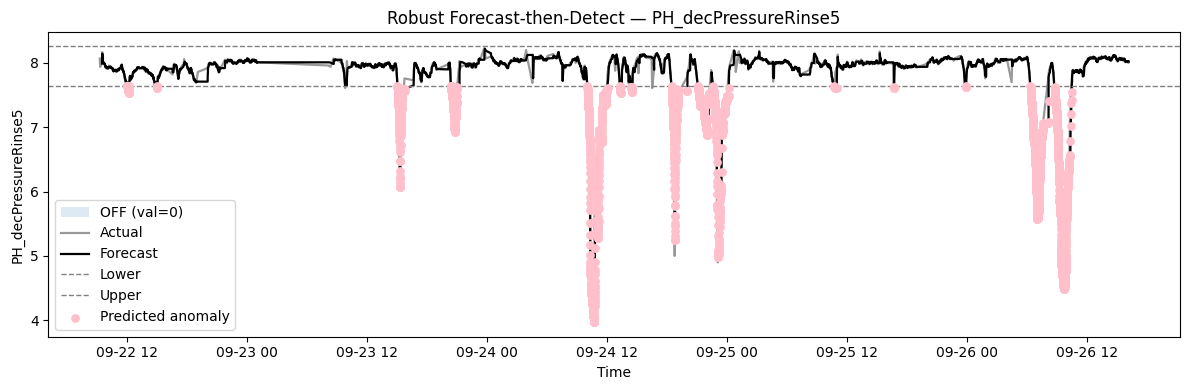

In [34]:
"""
Robust Forecast-then-Detect (single variable, all shifts merged)
- Forecast: rolling median (one-step ahead)
- Thresholds: median ± K * (1.4826 * MAD) estimated on a calibration window
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ===== Parameters =====
FILE     = "CP_10s.csv"
TS_COL   = "t10"
VAR      = "PH_decPressureRinse5"
MA_N     = 6          # rolling window for median forecast (10-min data -> 6 ≈ 1 hour)
CAL_FRAC = 0.70       # first 70% valid points for robust threshold estimation
K_MAD    = 3.0        # band width: median ± K * (1.4826 * MAD)
ROUND_N  = 3          # print rounding

# ===== Load & preprocess (parse t10, handle OFF=0) =====
def parse_t10(s):
    t = pd.to_datetime(s, format="%d%b%Y:%H:%M:%S", errors="coerce")
    if t.isna().any():
        t = t.fillna(pd.to_datetime(s, errors="coerce"))
    return t

df = pd.read_csv(FILE)
if TS_COL not in df.columns: raise ValueError(f"Time column '{TS_COL}' not found.")
if VAR not in df.columns:    raise ValueError(f"Column '{VAR}' not found.")

df["ts"] = parse_t10(df[TS_COL])
df = df.dropna(subset=["ts"]).sort_values("ts")

g = df[["ts", VAR]].copy()
g["val_raw"] = pd.to_numeric(g[VAR], errors="coerce")
g["is_off"]  = (g["val_raw"] == 0)
g["val"]     = g["val_raw"].where(~g["is_off"], np.nan)
g = g.drop(columns=[VAR])

if g["val"].notna().sum() == 0:
    raise ValueError(f"No valid points (val!=0) for {VAR}.")

# ===== Robust one-step forecast (rolling median) =====
g["yhat"] = g["val"].rolling(MA_N, min_periods=MA_N).median().shift(1)

# ===== Robust thresholds from calibration window (median ± K * 1.4826 * MAD) =====
val_valid = g["val"].dropna()
k = max(1, int(len(val_valid) * CAL_FRAC))
cal = val_valid.iloc[:k]

med = float(cal.median())
mad = float((cal - med).abs().median())
sigma = 1.4826 * mad if mad > 0 else 1e-8
lo = med - K_MAD * sigma
hi = med + K_MAD * sigma
lo_r = float(np.round(lo, ROUND_N))
hi_r = float(np.round(hi, ROUND_N))

print(f"Variable: {VAR}")
print(f"Calibration size: {k} / {len(val_valid)} valid points")
print(f"Median={med:.{ROUND_N}f}, MAD={mad:.{ROUND_N}f}, sigma_MAD={sigma:.{ROUND_N}f}")
print(f"Robust band: [{lo_r:.{ROUND_N}f}, {hi_r:.{ROUND_N}f}] (K={K_MAD})")

# ===== Predicted anomaly: yhat outside robust band (ignore OFF) =====
g["pred_anom"] = False
mask_pred = g["yhat"].notna() & (~g["is_off"])
g.loc[mask_pred & ((g["yhat"] < lo_r) | (g["yhat"] > hi_r)), "pred_anom"] = True
print(f"Predicted anomalies: {int(g['pred_anom'].sum())}")

# ===== Plot (English only; no saving) =====
vmin = np.nanmin([g["val"].min(), g["yhat"].min(), lo_r, hi_r])
vmax = np.nanmax([g["val"].max(), g["yhat"].max(), lo_r, hi_r])
if not np.isfinite(vmin) or not np.isfinite(vmax): vmin, vmax = 0.0, 1.0
pad = 0.05 * (vmax - vmin if vmax > vmin else 1.0)
y1, y2 = vmin - pad, vmax + pad

fig, ax = plt.subplots(figsize=(12, 4))
ax.fill_between(g["ts"], y1, y2, where=g["is_off"], alpha=0.15, label="OFF (val=0)")
ax.plot(g["ts"], g["val"],  color="0.6",  linewidth=1.6, label="Actual")
ax.plot(g["ts"], g["yhat"], color="black", linewidth=1.6, label="Forecast")
ax.axhline(lo_r, color="gray", linestyle="--", linewidth=1, label="Lower")
ax.axhline(hi_r, color="gray", linestyle="--", linewidth=1, label="Upper")
pink = g["pred_anom"] & g["yhat"].notna()
ax.scatter(g.loc[pink, "ts"], g.loc[pink, "yhat"], s=28, color="pink", zorder=3, label="Predicted anomaly")
ax.set_title(f"Robust Forecast-then-Detect — {VAR}")
ax.set_xlabel("Time"); ax.set_ylabel(VAR)
ax.legend(loc="best")
plt.tight_layout()
plt.show()


Forecast-then-Detect(傳統 6σ 門檻)

C:\Users\Sandy\AppData\Local\Temp\ipykernel_35144\1153339048.py:26: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ts = ts.fillna(pd.to_datetime(df[ts_name], errors="coerce"))


Target: PH_decPressureRinse5
Effective samples (val!=0): 17824
Calibration: first 70% of available data
Residual 6σ bounds (rounded): [-0.29, 0.29]
Value    6σ bounds (rounded): [4.68, 10.944]

Confusion matrix (rows=Actual, cols=Pred):
               Pred=Anom  Pred=Normal
Actual=Anom            1          218
Actual=Normal         96        17503

Actual anomalies: 97   Predicted anomalies: 219


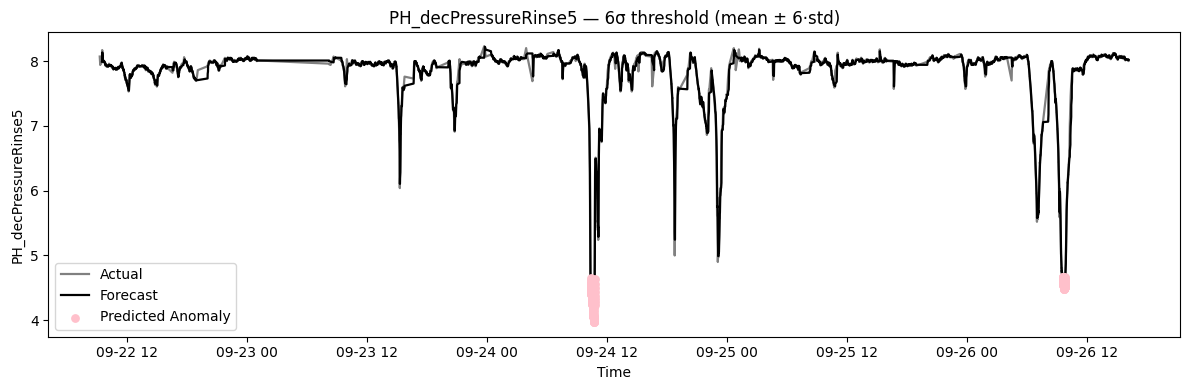

In [35]:
# -*- coding: utf-8 -*-
# Forecast-then-Detect with classic 6σ threshold (single variable)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Config ---
FILE      = "CP_10s.csv"
TS_COLS   = ["t10","create_date","timestamp","time","ts"]
VAR       = "PH_decPressureRinse5"
MA_N      = 6            # rolling window for one-step forecast
CAL_FRAC  = 0.70         # first 70% for calibration
K_SIGMA   = 6.0          # classic 6σ
ROUND_N   = 3            # print thresholds rounded to 3 decimals

# --- Read & time parse (supports '22SEP2025:09:19:40') ---
df = pd.read_csv(FILE)
ts_name = next((c for c in TS_COLS if c in df.columns), None)
if ts_name is None:
    raise ValueError("Time column not found.")
if VAR not in df.columns:
    raise ValueError(f"Column not found: {VAR}")

ts = pd.to_datetime(df[ts_name], format="%d%b%Y:%H:%M:%S", errors="coerce")
ts = ts.fillna(pd.to_datetime(df[ts_name], errors="coerce"))
df = df.assign(ts=ts).dropna(subset=["ts"]).sort_values("ts")

# --- Build series, treat 0 as OFF (excluded), keep OFF mask for shading ---
s = pd.to_numeric(df[VAR], errors="coerce")
is_off = (s == 0)
val = s.mask(is_off)  # OFF -> NaN, excluded from model
g = pd.DataFrame({"ts": df["ts"].values, "val": val.values, "is_off": is_off.values})

if g["val"].notna().sum() == 0:
    raise ValueError(f"No effective data (val!=0) for {VAR}.")

# --- One-step forecast (rolling mean) and residuals ---
g["yhat"] = g["val"].rolling(MA_N, min_periods=MA_N).mean().shift(1)
g["res"]  = g["val"] - g["yhat"]

# --- Calibration on first 70% of available samples ---
mask_eval = g["yhat"].notna() & g["val"].notna()
res_valid = g.loc[mask_eval, "res"]
val_valid = g["val"].dropna()

def head_frac(x, frac):
    return x.iloc[: max(1, int(len(x)*frac))] if len(x) else x

cal_res = head_frac(res_valid, CAL_FRAC)
cal_val = head_frac(val_valid, CAL_FRAC)

def six_sigma_bounds(x, k=6.0):
    x = pd.to_numeric(pd.Series(x), errors="coerce").dropna()
    if x.empty:
        return (np.nan, np.nan)
    mu = x.mean()
    sd = x.std(ddof=0)  # population std
    if not np.isfinite(sd) or sd == 0:
        return (np.nan, np.nan)
    return (mu - k*sd, mu + k*sd)

# --- Thresholds (classic mean ± 6·std) ---
low_res,  high_res  = six_sigma_bounds(cal_res, K_SIGMA)  # for "actual anomaly" label
low_val,  high_val  = six_sigma_bounds(cal_val, K_SIGMA)  # for "predicted anomaly" on yhat
low_res_r,  high_res_r  = [float(np.round(v, ROUND_N)) if pd.notna(v) else np.nan for v in (low_res, high_res)]
low_val_r,  high_val_r  = [float(np.round(v, ROUND_N)) if pd.notna(v) else np.nan for v in (low_val, high_val)]

# --- Labels for evaluation (confusion matrix) ---
g["y_true_actual_anom"] = False
if pd.notna(low_res_r) and pd.notna(high_res_r):
    g.loc[mask_eval & ((g["res"] < low_res_r) | (g["res"] > high_res_r)), "y_true_actual_anom"] = True

g["y_pred_anom"] = False
mask_pred = g["yhat"].notna() & (~g["is_off"])
if pd.notna(low_val_r) and pd.notna(high_val_r):
    g.loc[mask_pred & ((g["yhat"] < low_val_r) | (g["yhat"] > high_val_r)), "y_pred_anom"] = True

# --- Confusion matrix & counts (actual vs predicted anomalies) ---
y_true = g.loc[mask_eval, "y_true_actual_anom"]
y_pred = g.loc[mask_eval, "y_pred_anom"]
TP = int(((y_true == True)  & (y_pred == True)).sum())
FP = int(((y_true == False) & (y_pred == True)).sum())
FN = int(((y_true == True)  & (y_pred == False)).sum())
TN = int(((y_true == False) & (y_pred == False)).sum())

print(f"Target: {VAR}")
print(f"Effective samples (val!=0): {g['val'].notna().sum()}")
print(f"Calibration: first {int(CAL_FRAC*100)}% of available data")
print(f"Residual 6σ bounds (rounded): [{low_res_r}, {high_res_r}]")
print(f"Value    6σ bounds (rounded): [{low_val_r}, {high_val_r}]")
print("\nConfusion matrix (rows=Actual, cols=Pred):")
print(pd.DataFrame([[TP, FP],[FN, TN]],
                   index=["Actual=Anom","Actual=Normal"],
                   columns=["Pred=Anom","Pred=Normal"]))
print(f"\nActual anomalies: {int(y_true.sum())}   Predicted anomalies: {int(y_pred.sum())}")

# --- Plot (Actual=gray line, Forecast=black line, Predicted anomaly=pink dots; OFF as gray band) ---
vmin = np.nanmin([g["val"].min(), g["yhat"].min()])
vmax = np.nanmax([g["val"].max(), g["yhat"].max()])
if not np.isfinite(vmin) or not np.isfinite(vmax):
    vmin, vmax = 0.0, 1.0
pad = 0.05 * (vmax - vmin if vmax > vmin else 1.0)
y1, y2 = vmin - pad, vmax + pad

fig, ax = plt.subplots(figsize=(12, 4))
ax.fill_between(g["ts"], y1, y2, where=g["is_off"], alpha=0.15)                 # OFF band
ax.plot(g["ts"], g["val"],  color="0.5",  linewidth=1.6, label="Actual")        # gray line
ax.plot(g["ts"], g["yhat"], color="black", linewidth=1.6, label="Forecast")     # black line
mask_pink = g["y_pred_anom"] & g["yhat"].notna()
ax.scatter(g.loc[mask_pink, "ts"], g.loc[mask_pink, "yhat"], s=28, color="pink",
           label="Predicted Anomaly", zorder=3)                                  # pink dots
ax.set_title(f"{VAR} — 6σ threshold (mean ± {int(K_SIGMA)}·std)")
ax.set_xlabel("Time"); ax.set_ylabel(VAR)
ax.legend(); plt.tight_layout(); plt.show()


X̄–S 管制圖

C:\Users\Sandy\AppData\Local\Temp\ipykernel_35144\2341021409.py:20: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ts = pd.to_datetime(df[TS], format="%d%b%Y:%H:%M:%S", errors="coerce").fillna(pd.to_datetime(df[TS], errors="coerce"))


Baseline subgroups: 1782 / 2971
Sbar=0.012991 | S-chart: UCL=0.022293, CL=0.012991, LCL=0.003689
Xbarbar=7.788339 | Xbar-chart: UCL=7.821783, CL=7.788339, LCL=7.754896 (k=6)


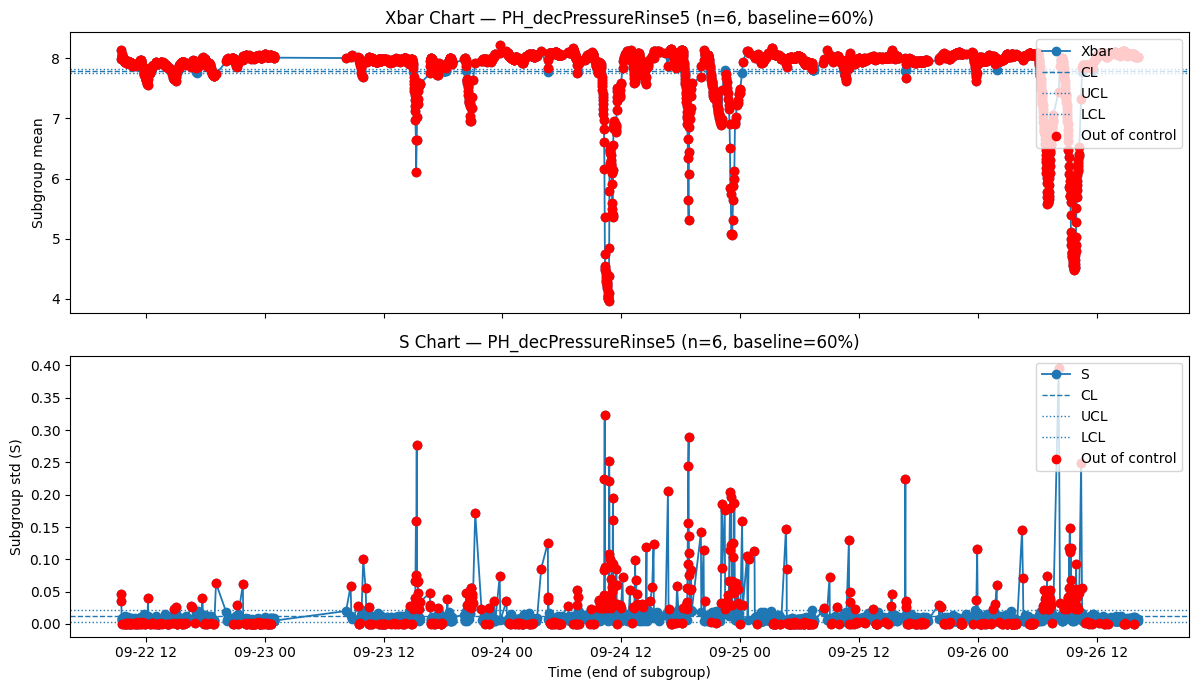

In [36]:
# Xbar–S control chart (subgroup n=6, baseline = first 60%)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ===== Parameters =====
FILE = "CP_10s.csv"
TS   = "t10"
VAR  = "PH_decPressureRinse5"
N = 6
BASE_FRAC = 0.60
K_SIGMA   = 6

# constants for n=6
c4 = 0.9515
B3, B4 = 0.284, 1.716

# ===== Load & preprocess =====
df = pd.read_csv(FILE)
ts = pd.to_datetime(df[TS], format="%d%b%Y:%H:%M:%S", errors="coerce").fillna(pd.to_datetime(df[TS], errors="coerce"))
df = df.assign(ts=ts).dropna(subset=["ts"]).sort_values("ts")
s = pd.to_numeric(df[VAR], errors="coerce")
val = s.mask(s == 0)  # OFF excluded
g = pd.DataFrame({"ts": df["ts"].values, "val": val.values})

# ===== Subgrouping and subgroup stats =====
g["grp"] = np.arange(len(g)) // N
grp = g.groupby("grp", as_index=False).agg(
    ts_end=("ts", "last"),
    XBAR=("val", "mean"),
    S=("val", lambda x: x.dropna().std(ddof=1))
)
rc = grp.dropna(subset=["XBAR","S"])
if rc.empty:
    raise ValueError("No valid subgroups (val!=0 too few).")

# ===== Baseline estimation (first 60% subgroups) =====
k = max(1, int(len(rc) * BASE_FRAC))
base = rc.iloc[:k]
Xbarbar = base["XBAR"].mean()
Sbar    = base["S"].mean()

# ===== Control limits =====
UCL_S = B4 * Sbar
LCL_S = B3 * Sbar
A3_k  = K_SIGMA / (c4 * np.sqrt(N))
UCL_X = Xbarbar + A3_k * Sbar
LCL_X = Xbarbar - A3_k * Sbar

print(f"Baseline subgroups: {k} / {len(rc)}")
print(f"Sbar={Sbar:.6f} | S-chart: UCL={UCL_S:.6f}, CL={Sbar:.6f}, LCL={LCL_S:.6f}")
print(f"Xbarbar={Xbarbar:.6f} | Xbar-chart: UCL={UCL_X:.6f}, CL={Xbarbar:.6f}, LCL={LCL_X:.6f} (k={K_SIGMA})")

# ===== Plot =====
fig, axes = plt.subplots(2, 1, figsize=(12, 7), sharex=True)

ax = axes[0]
ax.plot(rc["ts_end"], rc["XBAR"], marker="o", linewidth=1.3, label="Xbar")
ax.axhline(Xbarbar, linestyle="--", linewidth=1, label="CL")
ax.axhline(UCL_X,  linestyle=":",  linewidth=1, label="UCL")
ax.axhline(LCL_X,  linestyle=":",  linewidth=1, label="LCL")
out_x = (rc["XBAR"] > UCL_X) | (rc["XBAR"] < LCL_X)
ax.scatter(rc.loc[out_x,"ts_end"], rc.loc[out_x,"XBAR"], s=36, color="red", zorder=3, label="Out of control")
ax.set_title(f"Xbar Chart — {VAR} (n={N}, baseline={int(BASE_FRAC*100)}%)")
ax.set_ylabel("Subgroup mean")
ax.legend(loc="upper right")

ax = axes[1]
ax.plot(rc["ts_end"], rc["S"], marker="o", linewidth=1.3, label="S")
ax.axhline(Sbar, linestyle="--", linewidth=1, label="CL")
ax.axhline(UCL_S, linestyle=":", linewidth=1, label="UCL")
ax.axhline(LCL_S, linestyle=":", linewidth=1, label="LCL")
out_s = (rc["S"] > UCL_S) | (rc["S"] < LCL_S)
ax.scatter(rc.loc[out_s,"ts_end"], rc.loc[out_s,"S"], s=36, color="red", zorder=3, label="Out of control")
ax.set_title(f"S Chart — {VAR} (n={N}, baseline={int(BASE_FRAC*100)}%)")
ax.set_xlabel("Time (end of subgroup)")
ax.set_ylabel("Subgroup std (S)")
ax.legend(loc="upper right")

plt.tight_layout()
plt.show()


EWMA control chart

C:\Users\Sandy\AppData\Local\Temp\ipykernel_35144\159045127.py:22: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ts = pd.to_datetime(df[TS], format="%d%b%Y:%H:%M:%S", errors="coerce").fillna(pd.to_datetime(df[TS], errors="coerce"))


EWMA for PH_decPressureRinse5
lambda=0.2, L=3.0, cal_frac=0.6
mu0=7.788, sigma=0.560, sigma_z=0.187
Limits: LCL=7.229, CL=7.788, UCL=8.348
Valid points (val!=0): 17824
Predicted anomalies: 1510


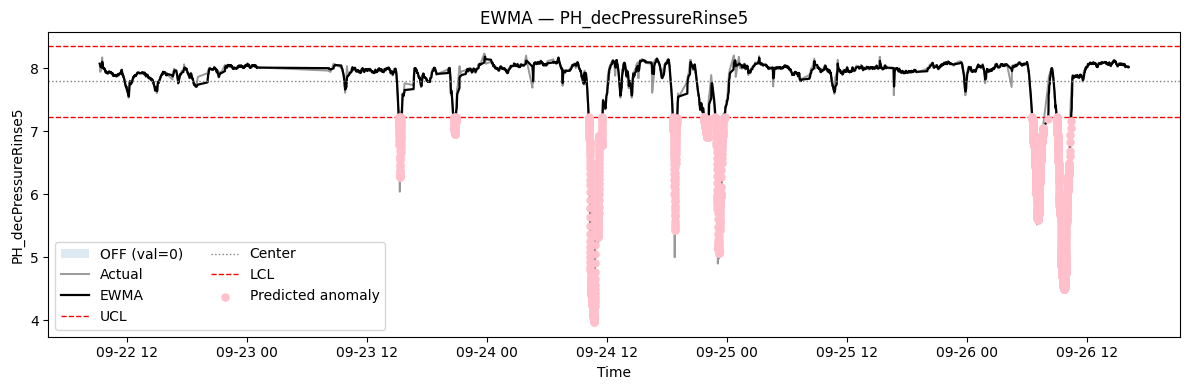

In [37]:
"""
EWMA control chart for a single variable.
- Limits (steady state): UCL/LCL = mu0 ± L * sigma * sqrt(lambda/(2-lambda))
- Plot: Actual=gray line, EWMA=black line, UCL/LCL=red dashed, Center=gray dotted, Predicted anomaly=pink dots, OFF=gray band
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Parameters
FILE     = "CP_10s.csv"
TS       = "t10"
VAR      = "PH_decPressureRinse5"
LAMBDA   = 0.20
L        = 3.0
CAL_FRAC = 0.60
ROUND_N  = 3

# Load data, parse time, define OFF=0 and keep valid series
df = pd.read_csv(FILE)
ts = pd.to_datetime(df[TS], format="%d%b%Y:%H:%M:%S", errors="coerce").fillna(pd.to_datetime(df[TS], errors="coerce"))
s  = pd.to_numeric(df[VAR], errors="coerce")
is_off = (s == 0)
val = s.mask(is_off)
g = pd.DataFrame({"ts": ts}).dropna().assign(val=val.loc[ts.notna()].values).sort_values("ts")
if g["val"].notna().sum() == 0:
    raise ValueError(f"{VAR} has no valid (val!=0) data.")

# Baseline estimation (mu0, sigma) from the first CAL_FRAC valid points
val_valid = g["val"].dropna()
k = max(1, int(len(val_valid) * CAL_FRAC)) if 0 < CAL_FRAC < 1 else len(val_valid)
cal = val_valid.iloc[:k]
mu0 = float(cal.mean())
sigma = float(cal.std(ddof=1))
if not np.isfinite(sigma) or sigma == 0:
    med = cal.median()
    mad = (cal - med).abs().median()
    sigma = 1.4826 * mad if mad > 0 else 1e-8
    mu0 = med

# EWMA over the full timeline (fill missing/OFF with mu0 so EWMA is continuous)
x = g["val"].fillna(mu0)
Z = x.ewm(alpha=LAMBDA, adjust=False).mean()

# Steady-state limits and anomaly mask (ignore OFF for markers)
sigma_z = sigma * np.sqrt(LAMBDA / (2.0 - LAMBDA))
UCL = mu0 + L * sigma_z
LCL = mu0 - L * sigma_z
pred_anom = (~g["val"].isna()) & ((Z > UCL) | (Z < LCL))

# Console summary
print(f"EWMA for {VAR}")
print(f"lambda={LAMBDA}, L={L}, cal_frac={CAL_FRAC}")
print(f"mu0={mu0:.{ROUND_N}f}, sigma={sigma:.{ROUND_N}f}, sigma_z={sigma_z:.{ROUND_N}f}")
print(f"Limits: LCL={LCL:.{ROUND_N}f}, CL={mu0:.{ROUND_N}f}, UCL={UCL:.{ROUND_N}f}")
print(f"Valid points (val!=0): {int(g['val'].notna().sum())}")
print(f"Predicted anomalies: {int(pred_anom.sum())}")

# Plot with OFF gray band, lines, limits, and pink anomaly dots
vmin = np.nanmin([g["val"].min(), Z.min()]); vmax = np.nanmax([g["val"].max(), Z.max()])
if not np.isfinite(vmin) or not np.isfinite(vmax): vmin, vmax = 0.0, 1.0
pad = 0.05 * (vmax - vmin if vmax > vmin else 1.0); y1, y2 = vmin - pad, vmax + pad

fig, ax = plt.subplots(figsize=(12, 4))
off_mask = s.loc[g.index].eq(0)
ax.fill_between(g["ts"], y1, y2, where=off_mask, alpha=0.15, label="OFF (val=0)")
ax.plot(g["ts"], g["val"], color="0.6", linewidth=1.4, label="Actual")
ax.plot(g["ts"], Z,        color="black", linewidth=1.6, label="EWMA")
ax.axhline(UCL, color="red",  linestyle="--", linewidth=1, label="UCL")
ax.axhline(mu0, color="gray", linestyle=":",  linewidth=1, label="Center")
ax.axhline(LCL, color="red",  linestyle="--", linewidth=1, label="LCL")
ax.scatter(g.loc[pred_anom, "ts"], Z.loc[pred_anom], s=26, color="pink", zorder=3, label="Predicted anomaly")
ax.set_title(f"EWMA — {VAR}"); ax.set_xlabel("Time"); ax.set_ylabel(VAR)
ax.legend(ncol=2); plt.tight_layout(); plt.show()


雙邊 CUSUM（Cumulative Sum）管制圖

C:\Users\Sandy\AppData\Local\Temp\ipykernel_35144\309934235.py:20: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ts = pd.to_datetime(df[TS], format="%d%b%Y:%H:%M:%S", errors="coerce").fillna(pd.to_datetime(df[TS], errors="coerce"))


CUSUM for PH_decPressureRinse5
cal_frac=0.6, mu0=7.788, sigma=0.560
k=0.280 (0.5·σ), h=2.798 (5.0·σ)
valid points (val!=0): 17824
predicted anomalies: 6173


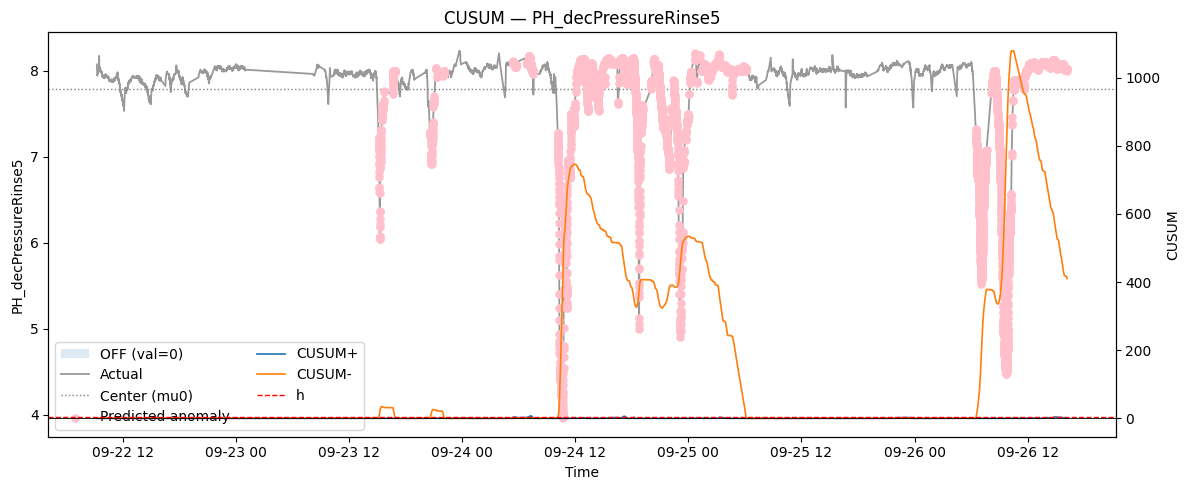

In [38]:
"""
Two-sided CUSUM control chart (single variable).
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Parameters
FILE      = "CP_10s.csv"
TS        = "t10"
VAR       = "PH_decPressureRinse5"
CAL_FRAC  = 0.60
K_SIGMA   = 0.5
H_SIGMA   = 5.0
ROUND_N   = 3

# Load & preprocess
df = pd.read_csv(FILE)
ts = pd.to_datetime(df[TS], format="%d%b%Y:%H:%M:%S", errors="coerce").fillna(pd.to_datetime(df[TS], errors="coerce"))
s  = pd.to_numeric(df[VAR], errors="coerce")
is_off = (s == 0)
val = s.mask(is_off)
g = pd.DataFrame({"ts": ts, "val": val, "is_off": is_off}).dropna(subset=["ts"]).sort_values("ts")
valid = g["val"].dropna()
if valid.empty:
    raise ValueError(f"{VAR} has no valid (val!=0) data.")

# Baseline estimation (mu0, sigma) from the first CAL_FRAC valid points
k_cal = max(1, int(len(valid) * CAL_FRAC)) if 0 < CAL_FRAC < 1 else len(valid)
cal = valid.iloc[:k_cal]
mu0 = float(cal.mean())
sigma = float(cal.std(ddof=1))
if not np.isfinite(sigma) or sigma == 0:
    med = cal.median()
    mad = (cal - med).abs().median()
    sigma = 1.4826 * mad if mad > 0 else 1e-8
    mu0 = med

# Two-sided CUSUM recursion
k = K_SIGMA * sigma
h = H_SIGMA * sigma
x = g["val"].fillna(mu0).to_numpy()
cpos = np.zeros_like(x, dtype=float)
cneg = np.zeros_like(x, dtype=float)
for i in range(1, len(x)):
    cpos[i] = max(0.0, cpos[i-1] + (x[i] - mu0 - k))
    cneg[i] = max(0.0, cneg[i-1] + (mu0 - x[i] - k))
g["cplus"] = cpos
g["cminus"] = cneg
pred_anom = ((g["cplus"] > h) | (g["cminus"] > h)) & (~g["is_off"])

# Console summary
print(f"CUSUM for {VAR}")
print(f"cal_frac={CAL_FRAC}, mu0={mu0:.{ROUND_N}f}, sigma={sigma:.{ROUND_N}f}")
print(f"k={k:.{ROUND_N}f} ({K_SIGMA}·σ), h={h:.{ROUND_N}f} ({H_SIGMA}·σ)")
print(f"valid points (val!=0): {int(g['val'].notna().sum())}")
print(f"predicted anomalies: {int(pred_anom.sum())}")

# Plot
vmin = np.nanmin([g["val"].min(), mu0]); vmax = np.nanmax([g["val"].max(), mu0])
if not np.isfinite(vmin) or not np.isfinite(vmax): vmin, vmax = 0.0, 1.0
pad = 0.05 * (vmax - vmin if vmax > vmin else 1.0); y1, y2 = vmin - pad, vmax + pad

fig, ax1 = plt.subplots(figsize=(12, 5))
ax1.fill_between(g["ts"], y1, y2, where=g["is_off"], alpha=0.15, label="OFF (val=0)")
ax1.plot(g["ts"], g["val"], color="0.6", linewidth=1.3, label="Actual")
ax1.axhline(mu0, color="gray", linestyle=":", linewidth=1, label="Center (mu0)")
ax2 = ax1.twinx()
ax2.plot(g["ts"], g["cplus"], color="tab:blue", linewidth=1.2, label="CUSUM+")
ax2.plot(g["ts"], g["cminus"], color="tab:orange", linewidth=1.2, label="CUSUM-")
ax2.axhline(h, color="red", linestyle="--", linewidth=1, label="h")
ax2.axhline(0, color="black", linewidth=0.6)
ax2.set_ylabel("CUSUM")
ax1.scatter(g.loc[pred_anom, "ts"], g.loc[pred_anom, "val"], s=26, color="pink", zorder=3, label="Predicted anomaly")
ax1.set_title(f"CUSUM — {VAR}"); ax1.set_xlabel("Time"); ax1.set_ylabel(VAR)
lines1, labels1 = ax1.get_legend_handles_labels(); lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="best", ncol=2)
plt.tight_layout(); plt.show()


變動門檻 (Rolling Threshold)

C:\Users\Sandy\AppData\Local\Temp\ipykernel_35144\3566658186.py:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  return p.fillna(pd.to_datetime(s, errors="coerce"))


Variable: PH_decPressureRinse5
Mode: Quantile [1%-99%], window=36, min_pts=12, round=3
Valid points (val!=0): 17824
Predicted anomalies: 2780


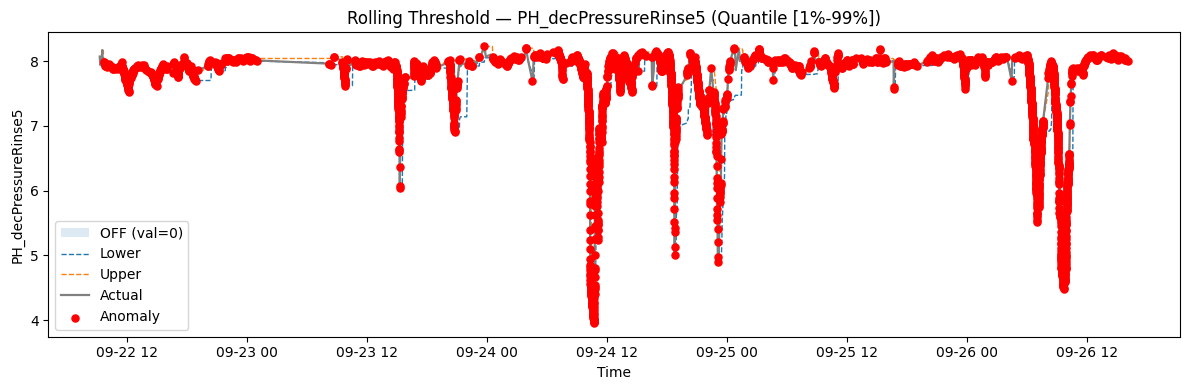

In [39]:
# -*- coding: utf-8 -*-
"""
Rolling Threshold (Quantile / MAD) for a single variable
- Data: CP_10s.csv, time column t10 ("22SEP2025:09:19:40")
- 0 -> OFF (excluded from stats and line; shaded gray in plot)
- Mode: "quantile" or "mad"
- Plot labels are English only
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ------- Parameters -------
FILE   = "CP_10s.csv"
TS_COL = "t10"
VAR    = "PH_decPressureRinse5"
MODE   = "quantile"      # "quantile" or "mad"
WIN_N  = 36              # rolling window length (10-min data -> 36 ≈ 6 hours)
MIN_PTS = 12             # minimum valid points inside window
ROUND_N = 3              # threshold rounding

Q_LOW, Q_HIGH = 0.01, 0.99   # for quantile mode
K_MAD = 3.0                  # for MAD mode: band = median ± K_MAD*(1.4826*MAD)

# ------- Helpers -------
def parse_t10(s):
    p = pd.to_datetime(s, format="%d%b%Y:%H:%M:%S", errors="coerce")
    return p.fillna(pd.to_datetime(s, errors="coerce"))

def roll_quantile(x, w, q, min_pts):
    out = np.full_like(x, np.nan, dtype=float)
    for i in range(len(x)):
        seg = x[max(0, i-w+1):i+1]
        seg = seg[~np.isnan(seg)]
        if seg.size >= min_pts:
            out[i] = np.quantile(seg, q)
    return out

def roll_median_mad(x, w, k, min_pts):
    m = np.full_like(x, np.nan, dtype=float)
    s = np.full_like(x, np.nan, dtype=float)
    for i in range(len(x)):
        seg = x[max(0, i-w+1):i+1]
        seg = seg[~np.isnan(seg)]
        if seg.size >= min_pts:
            med = np.median(seg)
            mad = np.median(np.abs(seg - med))
            m[i] = med
            s[i] = 1.4826 * mad
    return m - k*s, m + k*s

# ------- Load & preprocess -------
df = pd.read_csv(FILE)
ts = parse_t10(df[TS_COL])
v  = pd.to_numeric(df[VAR], errors="coerce")
is_off = (v == 0)
val = v.mask(is_off)
g = pd.DataFrame({"ts": ts, "val": val, "is_off": is_off}).dropna(subset=["ts"]).sort_values("ts")
x = g["val"].to_numpy(float)

# ------- Rolling thresholds -------
if MODE.lower() == "quantile":
    lower = roll_quantile(x, WIN_N, Q_LOW, MIN_PTS)
    upper = roll_quantile(x, WIN_N, Q_HIGH, MIN_PTS)
elif MODE.lower() == "mad":
    lower, upper = roll_median_mad(x, WIN_N, K_MAD, MIN_PTS)
else:
    raise ValueError("MODE must be 'quantile' or 'mad'.")

lower_r = np.round(lower, ROUND_N)
upper_r = np.round(upper, ROUND_N)

# ------- Predicted anomalies -------
pred_anom = (~np.isnan(x)) & (~g["is_off"].to_numpy()) & ((x < lower_r) | (x > upper_r))
n_valid = int(np.isfinite(x).sum())
n_pred  = int(pred_anom.sum())
mode_desc = f"Quantile [{int(Q_LOW*100)}%-{int(Q_HIGH*100)}%]" if MODE=="quantile" else f"MAD (k={K_MAD})"
print(f"Variable: {VAR}")
print(f"Mode: {mode_desc}, window={WIN_N}, min_pts={MIN_PTS}, round={ROUND_N}")
print(f"Valid points (val!=0): {n_valid}")
print(f"Predicted anomalies: {n_pred}")

# ------- Plot -------
vmin = np.nanmin([np.nanmin(x), np.nanmin(lower_r), np.nanmin(upper_r)])
vmax = np.nanmax([np.nanmax(x), np.nanmax(lower_r), np.nanmax(upper_r)])
if not np.isfinite(vmin) or not np.isfinite(vmax): vmin, vmax = 0.0, 1.0
pad = 0.05*(vmax - vmin if vmax > vmin else 1.0); y1, y2 = vmin - pad, vmax + pad

fig, ax = plt.subplots(figsize=(12, 4))
ax.fill_between(g["ts"], y1, y2, where=g["is_off"], alpha=0.15, label="OFF (val=0)")
ax.plot(g["ts"], lower_r, linestyle="--", linewidth=1, label="Lower")
ax.plot(g["ts"], upper_r, linestyle="--", linewidth=1, label="Upper")
ax.plot(g["ts"], g["val"], color="0.5", linewidth=1.6, label="Actual")
ax.scatter(g.loc[pred_anom, "ts"], g.loc[pred_anom, "val"], s=26, color="red", zorder=3, label="Anomaly")
ax.set_title(f"Rolling Threshold — {VAR} ({mode_desc})")
ax.set_xlabel("Time"); ax.set_ylabel(VAR)
ax.legend(); plt.tight_layout(); plt.show()
